In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import time
import json
from shapely.geometry import Point, Polygon

%matplotlib inline

In [2]:
# Import time-series NDVI data
tile_ndvi = pd.read_csv('COURSE_28818554_ndvi.csv')
print(tile_ndvi.shape)
tile_ndvi.head()

(262144, 213)


,nan-1,2015-11-18,2015-11-28,2016-02-06,2016-03-07,2016-03-27,2016-04-06,2016-04-16,2016-04-26,2016-05-06,...,2019-09-18,2019-09-23,2019-09-28,2019-10-03,2019-10-08,2019-10-13,2019-10-18,2019-10-23,2019-10-28,nan-2
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Get sugar indexes of the selected field
field_sugar_index = [int(line.rstrip('\n')) for line in open('COURSE_28818554_sugar_index.csv')]
field_sugar_index[:5]

[93079, 93080, 93081, 93082, 93083]

In [4]:
def mean_of_two_days(df, index, col):
    pre_value = df.iloc[index,col-1]
    next_value = df.iloc[index,col+1]
    if not np.isnan(pre_value) or not np.isnan(next_value):
        return np.nanmean([pre_value, next_value])
    else:
        return np.nan

In [5]:
def sugar_indexes_around(index, sugar_indexes):
    
    x = int(index/512)
    y = index % 512
    
    p1 = (x-1)*512 + (y-1)
    p2 = (x-1)*512 + (y)
    p3 = (x-1)*512 + (y+1)
    p4 = (x)*512 + (y-1)
    p5 = (x)*512 + (y+1)
    p6 = (x+1)*512 + (y-1)
    p7 = (x+1)*512 + (y)
    p8 = (x+1)*512 + (y+1)
    
    surround_indexes = [p1, p2, p3, p4, p5, p6, p7, p8]
    surround_sugar_indexes = [pixel for pixel in surround_indexes if pixel in sugar_indexes]
    
    return(surround_sugar_indexes)

In [6]:
# First Imputation
start_time = time.time()
print('\nFirst Imputation...')
ndvi_df_2 = tile_ndvi.copy()
iter_count = 0
for i in field_sugar_index:
    for j in range(1,len(ndvi_df_2.columns)-1):
        if np.isnan(ndvi_df_2.iloc[i,j]):
            mean_value = mean_of_two_days(ndvi_df_2, i, j)
            if not np.isnan(mean_value):
                ndvi_df_2.iloc[i,j] = mean_value
    iter_count += 1           
    if iter_count % 500 == 0:
        print('## %.2f%s' % (iter_count*100/len(field_sugar_index), '%'))
print("--- %s seconds ---" % (time.time() - start_time))


First Imputation...
## 13.71%
## 27.42%
## 41.13%
## 54.84%
## 68.55%
## 82.26%
## 95.97%
--- 110.50908589363098 seconds ---


In [7]:
# Second Imputation
start_time = time.time()
print('\nSecond Imputation...')
ndvi_df_3 = ndvi_df_2.copy()

iter_count = 1

while ndvi_df_3.iloc[field_sugar_index,1:len(ndvi_df_3.columns)-1].isnull().sum().sum() != 0:
    print('# Iter:', iter_count)
    # Fill with the average of 8 nearest points
    for col in range(1,len(ndvi_df_3.columns)-1):
        if ndvi_df_3.iloc[field_sugar_index,col].isnull().sum() == 0:
            continue
        else:
            col_name = ndvi_df_3.columns[col]
            print('## Start Imputing...', col, col_name)

            for index in field_sugar_index:
                if np.isnan(ndvi_df_3.iloc[index,col]):
                    nearest_sugar_indexes = sugar_indexes_around(index, field_sugar_index)
                    mean_value = np.mean(ndvi_df_3.iloc[nearest_sugar_indexes,col])
                    if not np.isnan(mean_value):
                        ndvi_df_3.iloc[index,col] = mean_value
    iter_count += 1

print("--- %s seconds ---" % (time.time() - start_time))


Second Imputation...
# Iter: 1
## Start Imputing... 1 2015-11-18
## Start Imputing... 2 2015-11-28
## Start Imputing... 3 2016-02-06
# Iter: 2
## Start Imputing... 1 2015-11-18
## Start Imputing... 2 2015-11-28
## Start Imputing... 3 2016-02-06
# Iter: 3
## Start Imputing... 1 2015-11-18
## Start Imputing... 2 2015-11-28
# Iter: 4
## Start Imputing... 1 2015-11-18
## Start Imputing... 2 2015-11-28
# Iter: 5
## Start Imputing... 1 2015-11-18
## Start Imputing... 2 2015-11-28
# Iter: 6
## Start Imputing... 1 2015-11-18
## Start Imputing... 2 2015-11-28
# Iter: 7
## Start Imputing... 1 2015-11-18
## Start Imputing... 2 2015-11-28
# Iter: 8
## Start Imputing... 1 2015-11-18
## Start Imputing... 2 2015-11-28
# Iter: 9
## Start Imputing... 1 2015-11-18
## Start Imputing... 2 2015-11-28
# Iter: 10
## Start Imputing... 1 2015-11-18
## Start Imputing... 2 2015-11-28
--- 6.020334959030151 seconds ---


In [8]:
def plot_1x3(array_1, array_2, array_3, figsize=(18.5,5), clim=True, colorbar=True):
    
    plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, 3)
    gs.update(wspace=0.025, hspace=0.025) # set the spacing between axes.
    
    # Plot 1
    ax1 = plt.subplot(gs[0])
    ax1.title.set_text('Missing')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    plt.imshow(array_1)
    if clim:
        plt.clim(-1, 1)
    if colorbar:
        plt.colorbar()
    
    # Plot 2
    ax2 = plt.subplot(gs[1])
    ax2.title.set_text('First Imputation')
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    plt.imshow(array_2)
    if clim:
        plt.clim(-1, 1)
    if colorbar:
        plt.colorbar()
    
    # Plot 3
    ax3 = plt.subplot(gs[2])
    ax3.title.set_text('Second Imputation')
    ax3.set_xticklabels([])
    ax3.set_yticklabels([])
    plt.imshow(array_3)
    if clim:
        plt.clim(-1, 1)
    if colorbar:
        plt.colorbar()

    plt.show()

2019-09-03


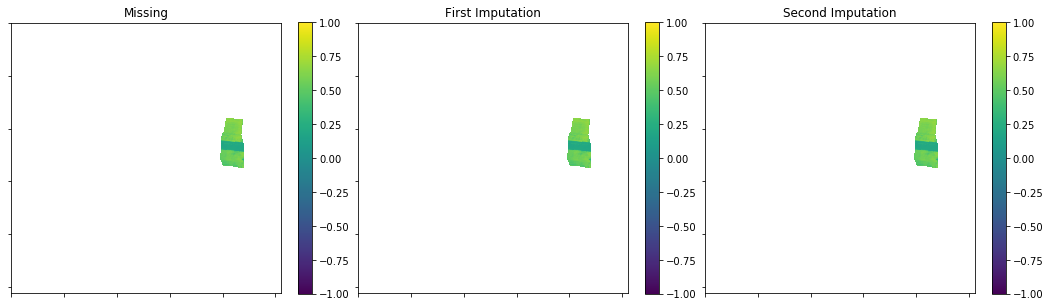

2019-09-08


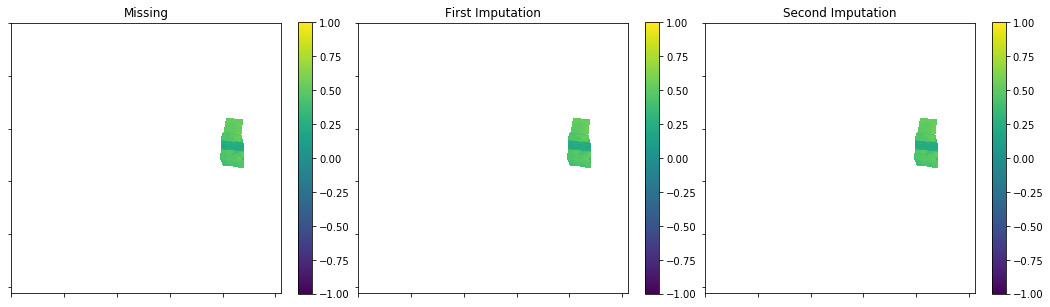

2019-09-13


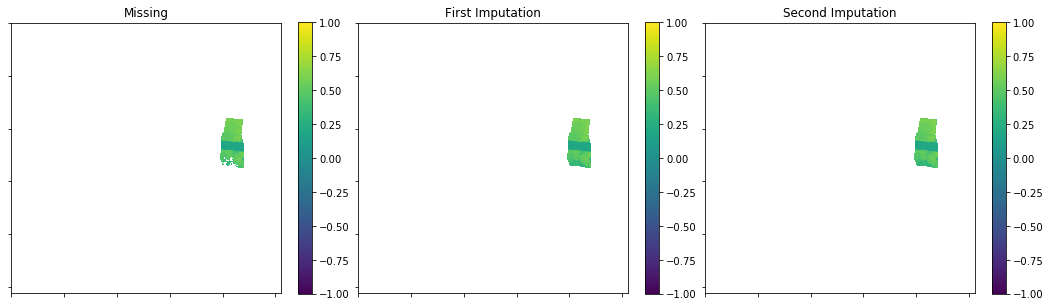

2019-09-18


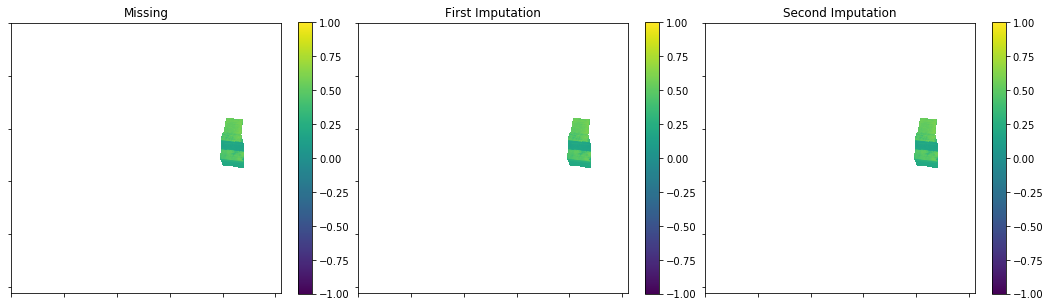

2019-09-23


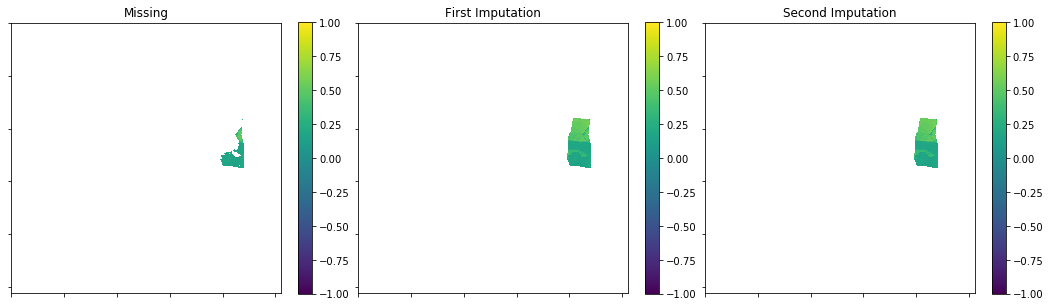

2019-09-28


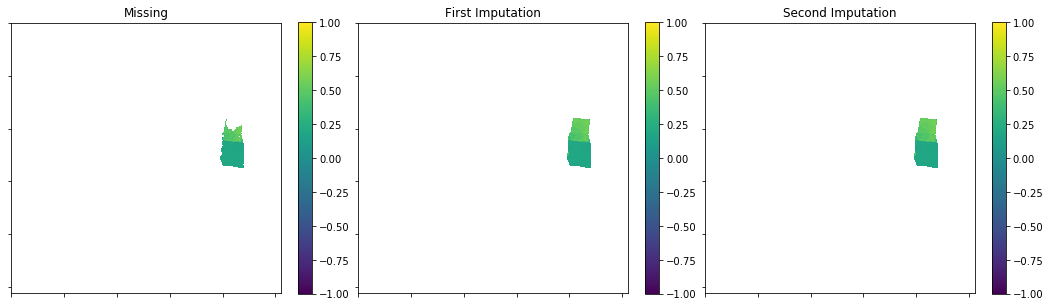

2019-10-03


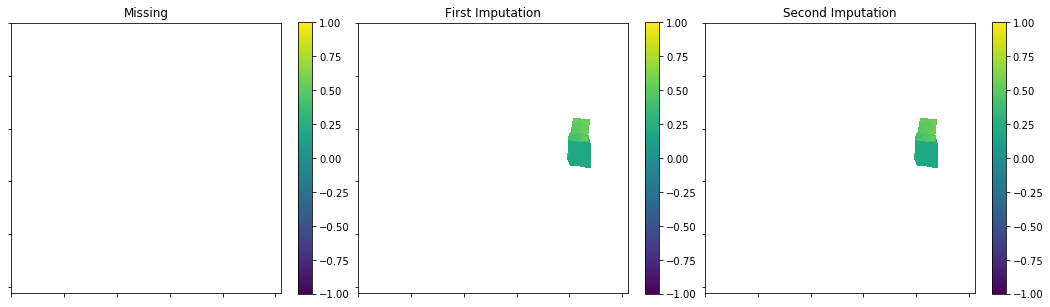

2019-10-08


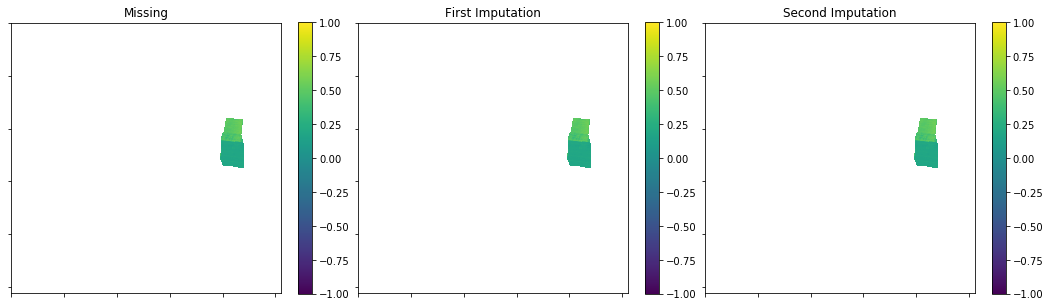

2019-10-13


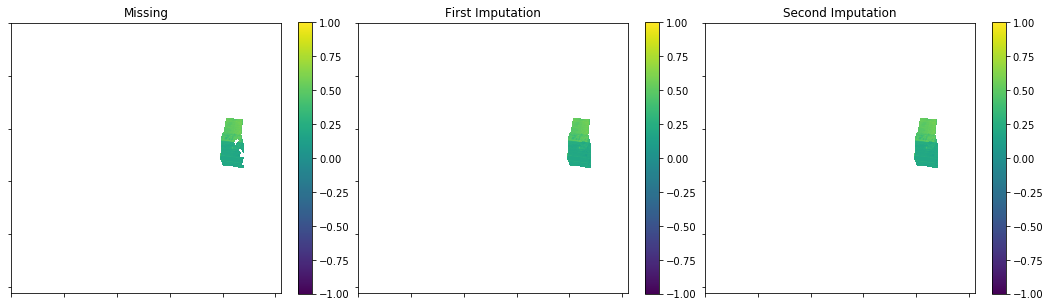

2019-10-18


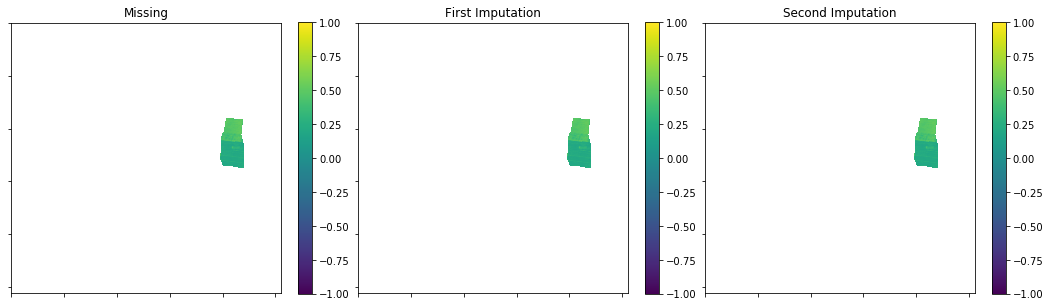

2019-10-23


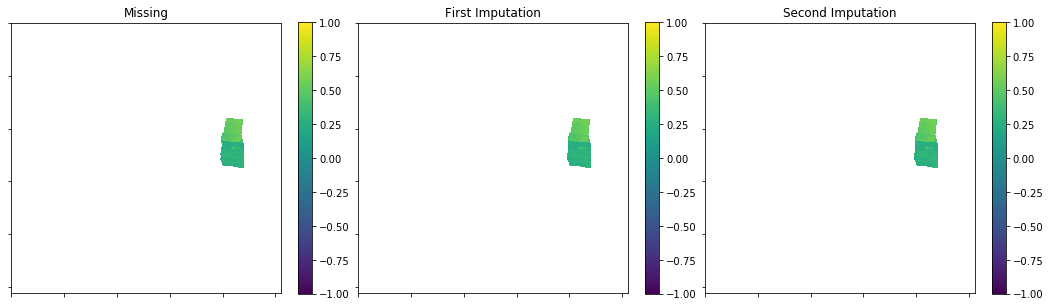

2019-10-28


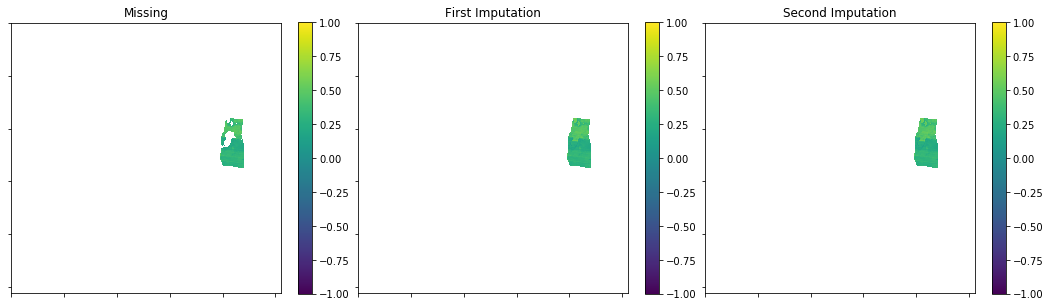

In [9]:
for j in range(200,len(tile_ndvi.columns)-1):
    print(tile_ndvi.columns[j])
    original_ndvi = tile_ndvi.iloc[:,j].values.copy().reshape((512, 512))
    fill_1_ndvi = ndvi_df_2.iloc[:,j].values.copy().reshape((512, 512))
    fill_2_ndvi = ndvi_df_3.iloc[:,j].values.copy().reshape((512, 512))
    plot_1x3(original_ndvi, fill_1_ndvi, fill_2_ndvi, clim=True, colorbar=True)

In [10]:
# Save the imputed NDVI data
ndvi_df_3.to_csv('COURSE_28818554_ndvi_filled.csv', index=False)